In [1]:
#Importing necessary libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE=512
BATCH_SIZE=16
CHANNELS=3
EPOCHS=50

In [3]:
#As all the images are not of same size so resizing them
from PIL import Image
import os, sys

path = "Data/Quartzite/"
dirs = os.listdir( path )

def resize():
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item).convert('RGB')
            f, e = os.path.splitext(path+item)
            print(item)
            imResize = im.resize((512,512), Image.ANTIALIAS)
            imResize.save(f + '.jpg', 'JPEG', quality=90)
            

#resize()

In [4]:
#Loading Dataset
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "Data",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2083 files belonging to 7 classes.


In [5]:
#Printing the name of the classes of rocks
class_names=dataset.class_names
print(class_names)

['Basalt', 'Coal', 'Granite', 'Limestone', 'Marble', 'Quartzite', 'Sandstone']


In [6]:
#print length of dataset
len(dataset)

131

In [7]:
65*32

2080

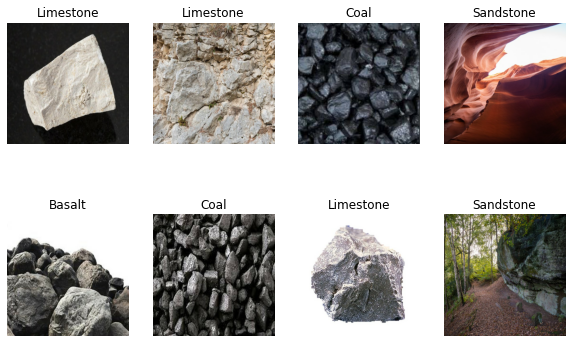

In [8]:
#Printing first 12 data in first batch
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(8):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

In [9]:
len(dataset)

131

In [10]:
# Training dataset=0.8, Validation set=0.1, test set =0.1
train_ds=dataset.take(52)
test_ds=dataset.skip(52)
val_ds=test_ds.take(7)
test_ds=test_ds.skip(7)

In [11]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    print(val_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    
    return train_ds,val_ds,test_ds

In [12]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

13


In [13]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

104
13
14


In [14]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [17]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=7
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(n_classes,activation="softmax"),
    
])
model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 512, 512, 3)         0         
                                                                 
 sequential_1 (Sequential)   (16, 512, 512, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 510, 510, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (16, 255, 255, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (16, 253, 253, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (16, 126, 126, 64)       0         
 2D)                                                  

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
104/104 [==============================] - 252s 2s/step - loss: 1.7717 - accuracy: 0.2556 - val_loss: 1.6339 - val_accuracy: 0.3606
Epoch 2/50
104/104 [==============================] - 256s 2s/step - loss: 1.5320 - accuracy: 0.4119 - val_loss: 1.4685 - val_accuracy: 0.3846
Epoch 3/50
104/104 [==============================] - 264s 3s/step - loss: 1.4683 - accuracy: 0.4185 - val_loss: 1.5113 - val_accuracy: 0.3942
Epoch 4/50
104/104 [==============================] - 277s 3s/step - loss: 1.4194 - accuracy: 0.4621 - val_loss: 1.4159 - val_accuracy: 0.4327
Epoch 5/50
104/104 [==============================] - 303s 3s/step - loss: 1.4093 - accuracy: 0.4543 - val_loss: 1.4025 - val_accuracy: 0.4231
Epoch 6/50
104/104 [==============================] - 255s 2s/step - loss: 1.4111 - accuracy: 0.4724 - val_loss: 1.4173 - val_accuracy: 0.4327
Epoch 7/50
104/104 [==============================] - 280s 3s/step - loss: 1.3933 - accuracy: 0.4591 - val_loss: 1.3705 - val_accuracy: 0.5000

In [21]:
scores=model.evaluate(test_ds)

14/14 [==============================] - 21s 781ms/step - loss: 0.8978 - accuracy: 0.6518


In [22]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

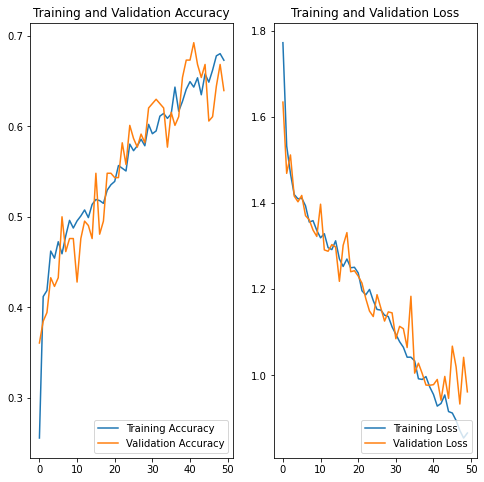

In [23]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label="Training Accuracy")
plt.plot(range(EPOCHS),val_acc,label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label="Training Loss")
plt.plot(range(EPOCHS),val_loss,label="Validation Loss")
plt.legend(loc="lower right")
plt.title('Training and Validation Loss')

first image to predict
first image actual label:  Marble
first image predicted label:  Marble
1/1 [==============================] - 1s 1s/step
Quartzite


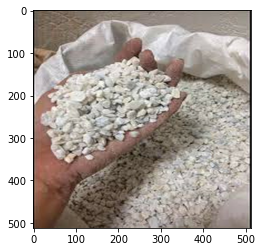

In [24]:
for images_batch, labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0]
    print('first image to predict')
    plt.imshow(first_image)
    print('first image actual label: ',class_names[first_label])
    print('first image predicted label: ',class_names[first_label])
    
    batch_prediction=model.predict(images_batch)
    print(class_names[np.argmax(batch_prediction[0])])

In [25]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 82ms/step


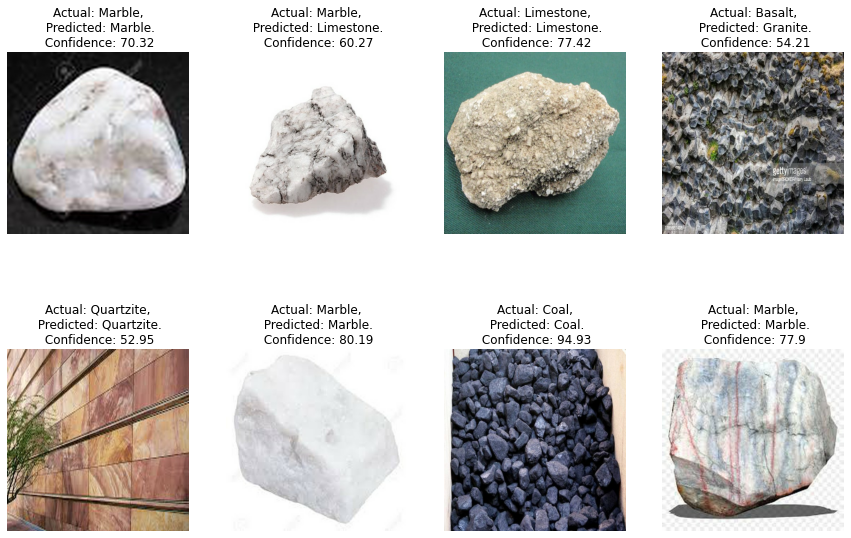

In [30]:
plt.figure(figsize=(15,10))
for images,labels in test_ds.take(3):
    for i in range(8):
        plt.subplot(2,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}")